In this notebook we run a simple system of purely repulsive spheres using a [Weeks-Chandler-Andersen potential](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.lj). We visualize the spheres using the povray backend and color them by distance to their nearest neighbor.

In [1]:
import flowws
import gtar
from hoomd_flowws.Init import Init
from hoomd_flowws.Interaction import Interaction
from hoomd_flowws.Run import Run

import plato, plato.draw.povray as draw
import freud
import numpy as np
import IPython
import ipywidgets

In [2]:
storage = flowws.DirectoryStorage()
stages = [
    Init(number=128),
    Interaction(
        type='lj', global_params=[('r_cut', 2**(1./6))],
        pair_params=[('A', 'A', 'epsilon', 1), ('A', 'A', 'sigma', 1)]),
    Run(steps=1e3, integrator='langevin'),
    Run(steps=1e4, integrator='langevin', compress_to=.57, dump_period=1e3),
]

flowws.Workflow(stages, storage).run();

HOOMD-blue v2.9.3 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 10/19/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using DEM. Please cite the following:
* M Spellings, R L Marson, J A Anderson, and S C Glotzer. "GPU accelerated
  Discrete Element Method (DEM) molecular dynamics for conservative, faceted
  particle simulations",  Journal of Computational Physics 334 (2017) 460--467
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the following GPU(s):
 [0]      GeForce

In [3]:
num_frames = 0

def get_frame(frame=-1):
    global num_frames
    with gtar.GTAR('dump.sqlite', 'r') as traj:
        (posRec, boxRec), frames = traj.framesWithRecordsNamed(['position', 'box'])

        num_frames = len(frames)
        positions = traj.getRecord(posRec, frames[frame])
        box = traj.getRecord(boxRec, frames[frame])
    return positions, box

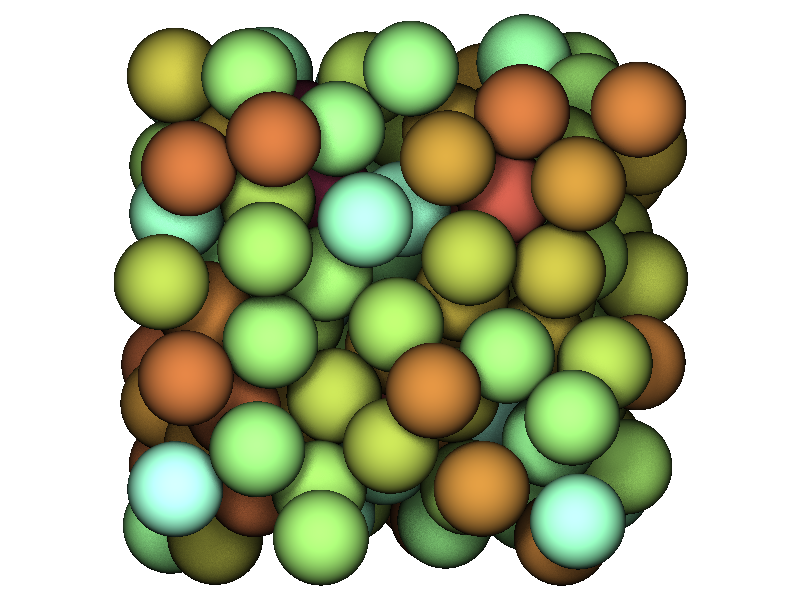

In [4]:
def update(scene, frame=-1):
    (positions, box) = get_frame(frame)

    # get nearest-neighbor distance, rescaled to go from 0-1, as cval
    fbox = freud.box.Box.from_box(box)
    nn = freud.locality.AABBQuery(fbox, positions)
    nlist = nn.query(positions, dict(exclude_ii=True, num_neighbors=1)).toNeighborList(True)
    cval = nlist.distances.copy()
    cval -= np.min(cval)
    cval /= np.max(cval)

    colors = plato.cmap.cubehelix(.25 + .5*cval)

    for prim in scene:
        prim.colors = colors
        prim.positions = positions
        prim.diameters = np.ones(len(positions))

prim = draw.Spheres()
features = dict(ambient_light=.4)
scene = draw.Scene(prim, features=features, zoom=4.8)
update(scene)

target = '../../gallery/flowws_spheres_povray.png'
scene.save(target)
IPython.display.Image(filename=target)

In [5]:
import plato.draw.vispy as interactive

live_scene = scene.convert(interactive)
live_scene.show()

@ipywidgets.interact(frame=(0, num_frames - 1))
def plot(frame=0):
    update(live_scene, frame)
    live_scene.render()

VispyWidget(height=600, width=800)

interactive(children=(IntSlider(value=0, description='frame', max=9), Output()), _dom_classes=('widget-interac…